In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup  # Check description below if not already installed
import seaborn as sns
import scipy

%pylab inline

sns.set_palette('Set2', 8)
sns.set_context("notebook")

Populating the interactive namespace from numpy and matplotlib


# 0. Description

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: `name`, `rank`, `country` and `region`, `number of faculty members` (international and total) and `number of students` (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
 * Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
 * Answer the previous question aggregating the data by (c) country and (d) region.

 Plot your data using bar charts and describe briefly what you observed.  <br>
 <br>
2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

## BeautifulSoup soup

BeautifulSoup is used to extract tags and information from webpage. To install the package please use the following command

```
conda install beautifulsoup4
```

# 1. topuniversities.com

Let's focus on the first website. If you go to www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)) you will see the first 25 top ranked universities. However if you look at the code source (HTML web page) you will not find occurence of MIT ranking informations. Let's use Console (ctrl-shift-k on Firefox, ctrl-shift-i on Chrome). You can see the web trafic (Network on Firefox and Chrome), i.e. every requests that are sent to properly display the webpage.


We can see that most of them are css files (.css), javascript files (.js) or images (.png). The website will load the images of each university, therfore we can assume that it needs to know what is the ranking to do so.

## 1.1 Main ranking information
If we look on the requests that happened when we load the page, we can find a XHR file (XML Http Request) https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt. It contains the universities names and attributes. If you click on the link you can see that it is a JSON file. The first level is a key named `data`. `data` is a vector and each element is a university with tags displayed below. We can keep `country`, `rank_display`, `score`, `title`, `region`. We can simply use request to isolate the informations from the previously cited tags and with pandas we can extract the informations from the web and store them in a dataframe.

In [2]:
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt')
print('Tags of JSON 1st level: {}'.format(r.json().keys()))
print('Tags of JSON 2nd level: {}'.format(r.json()['data'][0].keys()))

Tags of JSON 1st level: dict_keys(['data'])
Tags of JSON 2nd level: dict_keys(['country', 'title', 'region', 'stars', 'guide', 'core_id', 'nid', 'logo', 'cc', 'score', 'rank_display', 'url'])


In [3]:
top_uni_df = pd.DataFrame(r.json()['data'], columns=['title', 'country', 'region', 'rank_display', 'score', 'url'])
top_uni_df.iloc[25:30]

,title,country,region,rank_display,score,url
25,The University of Hong Kong,Hong Kong,Asia,26,85.5,/universities/university-hong-kong
26,"University of California, Berkeley (UCB)",United States,North America,27,84.9,/universities/university-california-berkeley-ucb
27,The University of Tokyo,Japan,Asia,=28,84.8,/universities/university-tokyo
28,Northwestern University,United States,North America,=28,84.8,/universities/northwestern-university
29,The Hong Kong University of Science and Techno...,Hong Kong,Asia,30,84.3,/universities/hong-kong-university-science-tec...


Note that some universities have the same rank. In this case the rank number will be `=X` where `X` is the ranking number. We cannot only cast it to integer we have to remove `=` first. We also complete the url for each university with `url` = `https://www.topuniversities.com` + `url` + `#wurs` according to href link of website. We will need this URL to fetch additional information about the university.

In [4]:
top_uni_df['score'] = pd.to_numeric(top_uni_df['score'], errors='coerce')
top_uni_df['rank_display'] = pd.to_numeric(top_uni_df['rank_display'].map(lambda x: x.lstrip('=')), errors='coerce')
top_uni_df['url'] = top_uni_df['url'].map(lambda x: 'https://www.topuniversities.com' + x + '#wurs')
top_uni_df = top_uni_df.sort_values(by='score', ascending=False).iloc[:200]
top_uni_df.head()

,title,country,region,rank_display,score,url
0,Massachusetts Institute of Technology (MIT),United States,North America,1.0,100.0,https://www.topuniversities.com/universities/m...
1,Stanford University,United States,North America,2.0,98.7,https://www.topuniversities.com/universities/s...
2,Harvard University,United States,North America,3.0,98.4,https://www.topuniversities.com/universities/h...
3,California Institute of Technology (Caltech),United States,North America,4.0,97.7,https://www.topuniversities.com/universities/c...
4,University of Cambridge,United Kingdom,Europe,5.0,95.6,https://www.topuniversities.com/universities/u...


We perform a sanity check to see that there are no NaN values in our dataframe

In [5]:
np.sum(top_uni_df.isnull())

title           0
country         0
region          0
rank_display    0
score           0
url             0
dtype: int64

## 1.2 Universities detailed informations

We still need to find `number of faculty members` (international and total) and `number of students` (international and total). To do so we will use the `url` field that contains the URL to the page that describe the university. If we look, for example, at the [MIT](https://www.topuniversities.com/universities/massachusetts-institute-technology-mit#wurs) we can see that there are plots displaying the Number of academic faculty staff aka `number of faculty members` and `number of students`. 

Looking at the source code allow us to see that thoses values are hard coded in the web page. We can therefore use BS4 to directly get the infos. All values are located inside `<div>` tags and have `class='number'`

In [6]:
from log import log_progress  # Fancy progress display
# Will contain the university info as [faculty_total, faculty_international, student_total, student_international]
infos = np.ones((len(top_uni_df), 4))*np.nan  
for i, url in log_progress(enumerate(top_uni_df['url']), every=1, size=len(top_uni_df)): 
    try:
        # Get request for specific university
        r_uni = requests.get(url)
        soup = BeautifulSoup(r_uni.text, 'html.parser')
        # Parse file to get specific informations about faculty and stuent (according to website html structure)
        faculty = soup.find('div', class_='faculty-main')
        infos[i, 0:2] = [int(val.text.replace(',', '')) for val in faculty.find_all('div', class_='number')]
        infos[i, 2] = int(soup.find('div', class_='students-main').find('div', class_='number').text.replace(',', ''))
        infos[i, 3] = int(soup.find('div', class_='int-students-main').find('div', class_='number').text.replace(',', ''))
    except Exception as e:
        print('Unable to find fields:', url)

VBox(children=(HTML(value=''), IntProgress(value=0, max=200)))

Unable to find fields: https://www.topuniversities.com/universities/new-york-university-nyu#wurs


Once the requests are performed and values loaded we can affect them to their respective fields. Note that [New York University](https://www.topuniversities.com/universities/new-york-university-nyu#wurs) does not have informations about students and faculties members. Therefore the values will be set to NaN. <br>

We assign the `title` column (name of university) as the index for our datframe and we check to see if it is unique.

In [7]:
top_uni_df['faculty_tot'] = infos[:, 0]
top_uni_df['faculty_int'] = infos[:, 1]
top_uni_df['student_tot'] = infos[:, 2]
top_uni_df['student_int'] = infos[:, 3]
top_uni_df.set_index(['title'], inplace=True)
print('Is index unique: {}'.format(top_uni_df.index.is_unique))
top_uni_df.head()

Is index unique: True


,country,region,rank_display,score,url,faculty_tot,faculty_int,student_tot,student_int
title,,,,,,,,,
Massachusetts Institute of Technology (MIT),United States,North America,1.0,100.0,https://www.topuniversities.com/universities/m...,2982.0,1679.0,11067.0,3717.0
Stanford University,United States,North America,2.0,98.7,https://www.topuniversities.com/universities/s...,4285.0,2042.0,15878.0,3611.0
Harvard University,United States,North America,3.0,98.4,https://www.topuniversities.com/universities/h...,4350.0,1311.0,22429.0,5266.0
California Institute of Technology (Caltech),United States,North America,4.0,97.7,https://www.topuniversities.com/universities/c...,953.0,350.0,2255.0,647.0
University of Cambridge,United Kingdom,Europe,5.0,95.6,https://www.topuniversities.com/universities/u...,5490.0,2278.0,18770.0,6699.0


## 1.3 Results 

### (a) - (b)

We dont have to create new fields. All values are already present in our dataframe. We therefore express :
* (a) ratio between faculty members and students as `faculty_tot`/`student_tot` 
* (b) ratio of international students as `student_int`/`student_tot`

For both plots we decided to sort results according to higher value and plot only the 30 first results for sake of visibility. We also compute the mean of staff vs student ratio and the one of international student vs total student ratio.

In [8]:
from textwrap import wrap

def nice_bar_plot(data, ax, title='', y_axis=''):
    ax.set_title(title , fontsize=12, fontweight='bold')
    ax.set_ylabel(y_axis)
    labels = [ '\n'.join(wrap(l, 15)) for l in data.index ]
    sns.set
    g = sns.barplot(x=labels, y=data.values,  ax=ax)
    [lab.set_rotation(45) for lab in ax.get_xticklabels()]

Mean of staff vs student ratio : 0.13
Mean of international student vs student total ratio : 0.21


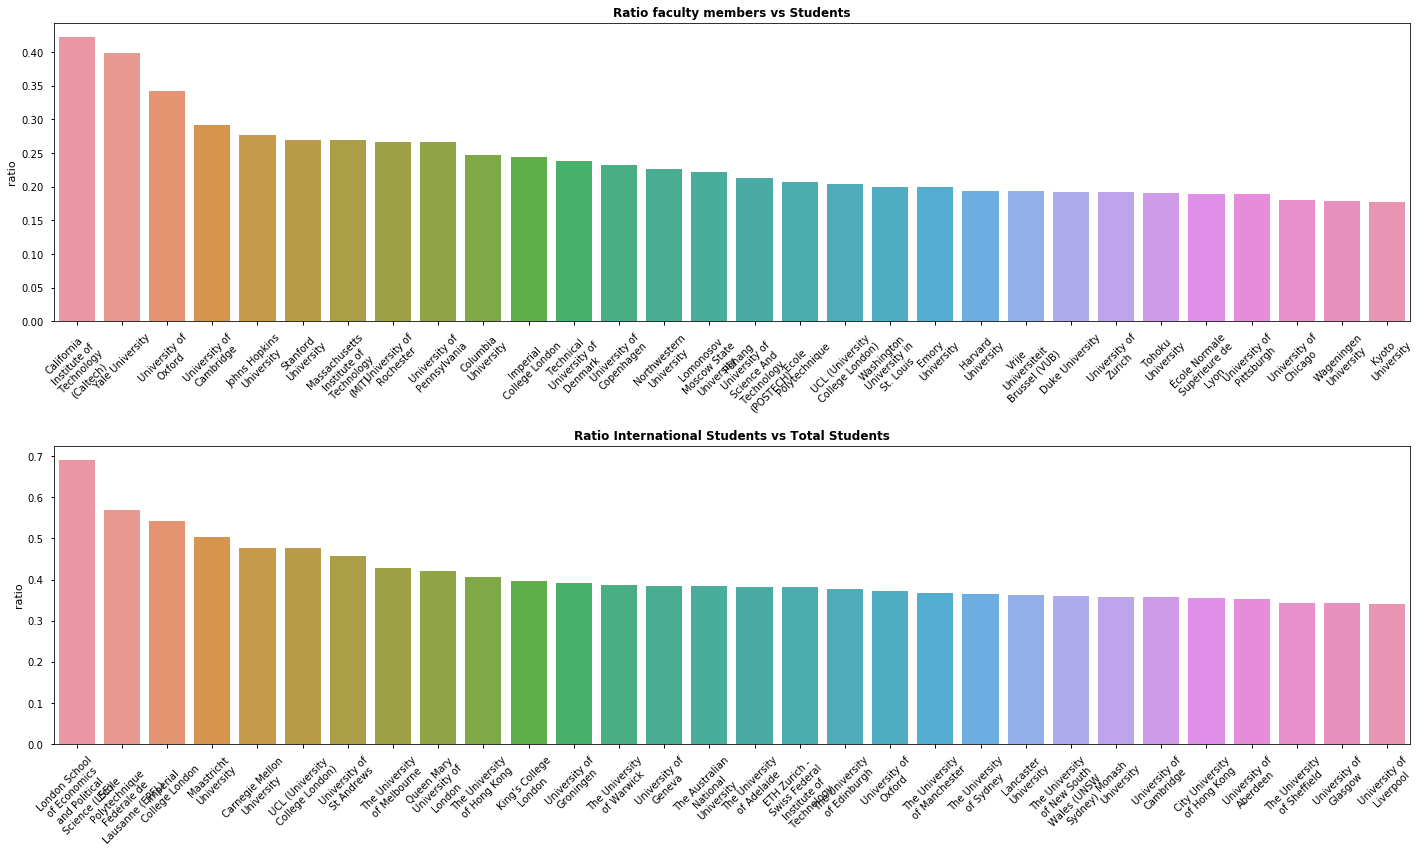

In [9]:
N_TOP = 30 # show only the 30th first uni
fig, axes = plt.subplots(2, 1, figsize=(20,12))
# Ratio faculty_tot / student_tot
fac_vs_stu = top_uni_df['faculty_tot'].div(top_uni_df['student_tot']).sort_values(ascending=False)
mean_fac_vs_stu = fac_vs_stu.mean()
nice_bar_plot(fac_vs_stu.iloc[:N_TOP], title='Ratio faculty members vs Students', y_axis='ratio', ax=axes[0])
# Ratio student_int / student_tot
stu_vs_int = top_uni_df['student_int'].div(top_uni_df['student_tot']).sort_values(ascending=False)
mean_stu_vs_int = stu_vs_int.mean()
nice_bar_plot(stu_vs_int.iloc[:N_TOP], title='Ratio International Students vs Total Students', y_axis='ratio', ax=axes[1])
plt.tight_layout()

print("Mean of staff vs student ratio : {:0.2f}".format(mean_fac_vs_stu))
print("Mean of international student vs student total ratio : {:0.2f}".format(mean_stu_vs_int))


* (a) It is interesting to notice that the universities with the higher staff/student ratio are not the one that are ranked first in the ranking. For example, the MIT, ranked first, is only the 7th of the staff/ratio student. As a comparison point, we computed the mean, 0.13, which is very low comparing to the higher scores we have displayed.
* (b) Here again, we can notice that university with higher ratio of international student are not the best ranked. We can notice some very international universities with a ratio much higher than the average of 0.21 that we could compute.

#### (c) `Country`
Same logic as before, except we need to group entries by `country`

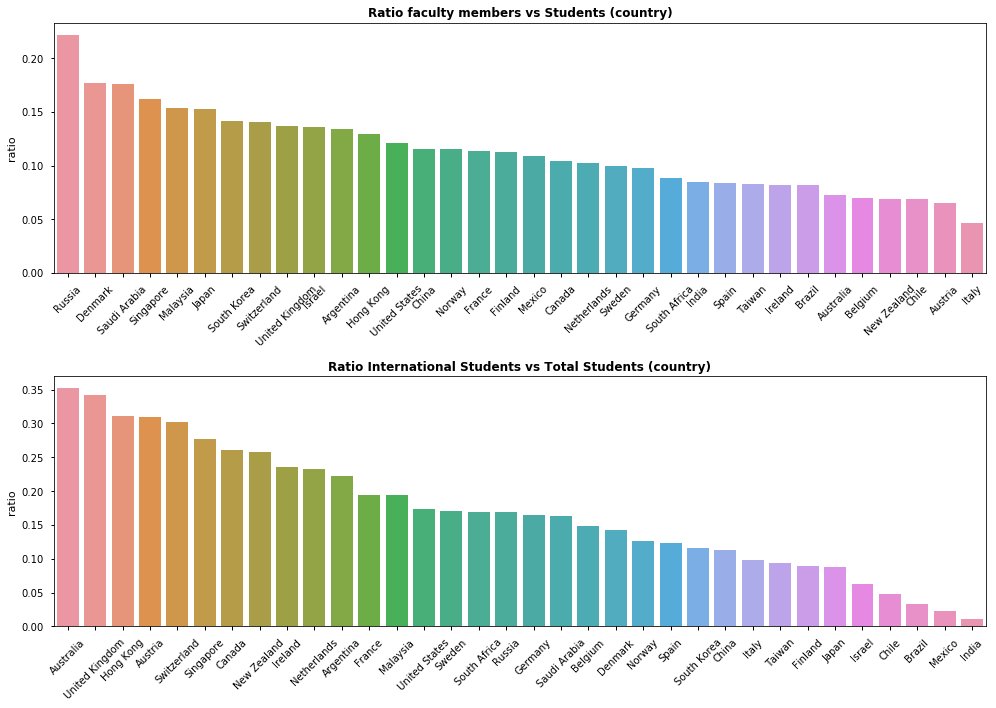

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14,10))
# Ratio faculty_tot / student_tot (country)
fac_vs_stu = top_uni_df.groupby('country')['faculty_tot'].sum().div(top_uni_df.groupby('country')['student_tot'].sum())\
                .sort_values(ascending=False)
nice_bar_plot(fac_vs_stu, title='Ratio faculty members vs Students (country)', y_axis='ratio', ax=axes[0])
# Ratio student_int / student_tot
stu_vs_int = top_uni_df.groupby('country')['student_int'].sum().div(top_uni_df.groupby('country')['student_tot'].sum())\
                .sort_values(ascending=False)
nice_bar_plot(stu_vs_int, title='Ratio International Students vs Total Students (country)', y_axis='ratio', ax=axes[1])
plt.tight_layout()

When grouping by country, we see that for the ratio of faculty members vs students, the countries with most universities in the top 50 (USA and UK) do not have a very high ratio value.

As for the ratio of international student vs total student grouped by countries, we can see that specific countries known as rich western countries are more likely to have an above average rate of international student. It is interesting to see that the 4 countries with the fewer rate are all emerging countries.

#### (d) `Region`

Same logic as before, except we need to group entries by `region`

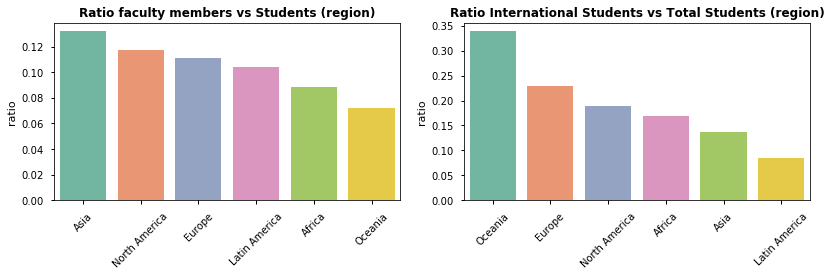

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
# Ratio faculty_tot / student_tot (country)
fac_vs_stu = top_uni_df.groupby('region')['faculty_tot'].sum().div(top_uni_df.groupby('region')['student_tot'].sum())\
                .sort_values(ascending=False)
nice_bar_plot(fac_vs_stu, title='Ratio faculty members vs Students (region)', y_axis='ratio', ax=axes[0])
# Ratio student_int / student_tot
stu_vs_int = top_uni_df.groupby('region')['student_int'].sum().div(top_uni_df.groupby('region')['student_tot'].sum())\
                .sort_values(ascending=False)
nice_bar_plot(stu_vs_int, title='Ratio International Students vs Total Students (region)', y_axis='ratio', ax=axes[1])
plt.tight_layout()

Now we can see that the region with the higher ratio of faculty member vs student is Asia, and it's interesting to see that it is also the region where there is, on average, a low ratio of international student. We could have guess the opposite as a university with more staff vs student ratio could be more appealing for a student to come and study there. However, let's not forget what has been stated above regarding the western countries that are more likely to have a higher number of international student than emerging countries.

#### Saving dataframe
In order to avoid redoing the crowling each time, we can save our dataframe as a csv for further use.

In [12]:
top_uni_df.to_csv('top_uni.csv')  # Backup (just run fetch once)

## 2. timeshighereducation.com

We can now look at the second website : https://www.timeshighereducation.com. On the [ranking 2018](https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats) page we can also see the first 25 ranked universities. By inspecting the source code of the webpage you can see that the informations we want to retrieve are not hard coded but are fetch from other links - same as for the first website. 

### 2.1 Main ranking information

We used the same approach as for the top-university website and used the console to see the requests sent by the page when it loads. We could identify a [link](https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json) to a JSON file. <br>
While inspecting this file, we could find 4 first level key, especially one called `data` containing the tags related to what we are looking for, i.e. `name`, `location`, `rank`, `stats_number_students`. We found also that we could retrieve the student-staff ratio, `stats_student_staff_ratio`, which will be use to compute the number of faculty members later on. There is also the percentage of international student, `stats_pc_intl_students`, that we can use to compute the number of international students. We decided to keep the score, `scores_overall`, from each university as we think it can be useful for the second part of the exercise.

We then proceed to store all those data in a dataframe.

In [13]:
URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
r = requests.get(URL)
print('Tags of JSON 1st level: {}'.format(r.json().keys()))
print('Tags of JSON 2nd level: {}'.format(r.json()['data'][0].keys()))

Tags of JSON 1st level: dict_keys(['locations', 'pillars', 'subjects', 'data'])
Tags of JSON 2nd level: dict_keys(['rank_order', 'record_type', 'scores_research_rank', 'stats_pc_intl_students', 'scores_citations', 'stats_number_students', 'scores_teaching', 'rank', 'scores_teaching_rank', 'stats_female_male_ratio', 'member_level', 'scores_citations_rank', 'scores_industry_income', 'scores_research', 'scores_international_outlook', 'scores_overall_rank', 'scores_industry_income_rank', 'name', 'nid', 'subjects_offered', 'aliases', 'stats_student_staff_ratio', 'location', 'scores_overall', 'scores_international_outlook_rank', 'url'])


In [14]:
the_df = pd.DataFrame(r.json()['data'], columns=['name', 'location', 'rank', 'scores_overall', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio'])
the_df.head()

,name,location,rank,scores_overall,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,University of Oxford,United Kingdom,1,94.3,"20,409",38%,11.2
1,University of Cambridge,United Kingdom,2,93.2,"18,389",35%,10.9
2,California Institute of Technology,United States,=3,93.0,"2,209",27%,6.5
3,Stanford University,United States,=3,93.0,"15,845",22%,7.5
4,Massachusetts Institute of Technology,United States,5,92.5,"11,177",34%,8.7


### 2.2 - Clean the Data

We have extracted raw data from the JSON file, now we would like to perform some data cleaning and computation on certain columns to have matching data with the other website. To do so we will convert the column `stats_number_students`,  `stats_pc_intl_students` and `stats_student_staff_ratio` to numerical values, then we will perform the computation to get `student_int`, the number of international students and `faculty_tot`, the number of faculty members. We also get rid of the "=" in the `rank` column that meant an equality rank for two or more universities and convert the column to numeric entries. Same goes for score that we convert to numeric.  

In [15]:
#Some Data Cleaning
the_df['scores_overall'] = pd.to_numeric(the_df['scores_overall'], errors='coerce')
the_df['rank'] = pd.to_numeric(the_df['rank'].map(lambda x: x.lstrip('=')), errors='coerce')
the_df['stats_pc_intl_students'] = pd.to_numeric(the_df['stats_pc_intl_students'].map(lambda x: x.rstrip('%')), errors='coerce')
the_df['stats_number_students'] = pd.to_numeric(the_df['stats_number_students'].str.replace(',', ''), errors='coerce')
the_df['stats_student_staff_ratio'] = pd.to_numeric(the_df['stats_student_staff_ratio'], errors='coerce')
# Find number of Intl Student from % and total nber student after cleaning
the_df['student_int'] = (the_df['stats_pc_intl_students'] * the_df['stats_number_students'] / 100).round().astype(int)
the_df['faculty_tot'] = (the_df['stats_number_students'] / the_df['stats_student_staff_ratio']).round().astype(int)

Once we have matching data regarding to the dataframe generated from top-university website we rename the columns such that their names match the names from the top-university dataframe to ease the merge. <br>
Note that for the moment we keep the `stats_student_staff_ratio` and `stats_pc_intl_students` because they will be useful after, even if those entries are not present in the top_uni dataframe.

We then check if there is any NaN to make sure our dataframe as been correctly cleaned.

In [16]:
the_df.columns = ['title', 'country', 'rank_display', 'score', 
                  'student_tot', 'stats_pc_intl_students', 'stats_student_staff_ratio',
                  'student_int', 'faculty_tot']
the_df = the_df.sort_values(by='score', ascending=False).iloc[:200]
np.sum(the_df.isnull())

title                        0
country                      0
rank_display                 0
score                        0
student_tot                  0
stats_pc_intl_students       0
stats_student_staff_ratio    0
student_int                  0
faculty_tot                  0
dtype: int64

Now that we are sure to have a clean dataset, we can set the name of university as index. We then check if our index `title` is unique

In [17]:
the_df.set_index(['title'], inplace=True)
print('Is index unique: {}'.format(the_df.index.is_unique))
the_df.head()

Is index unique: True


,country,rank_display,score,student_tot,stats_pc_intl_students,stats_student_staff_ratio,student_int,faculty_tot
title,,,,,,,,
University of Oxford,United Kingdom,1.0,94.3,20409,38,11.2,7755,1822
University of Cambridge,United Kingdom,2.0,93.2,18389,35,10.9,6436,1687
California Institute of Technology,United States,3.0,93.0,2209,27,6.5,596,340
Stanford University,United States,3.0,93.0,15845,22,7.5,3486,2113
Massachusetts Institute of Technology,United States,5.0,92.5,11177,34,8.7,3800,1285


### 2.3 Results

We will reuse the plot function define above to plot our data.
* (a) We will use the `stats_student_staff_ratio` directly available from the website.
* (b) We will use the `stats_pc_intl_students` retrieved from the website.

Same as before, for a sake of visibility, we only plot the 30 first universities

### (a) - (b)

Mean of staff vs student ratio : 17.79%
Mean of international student vs student total ratio : 21.86%


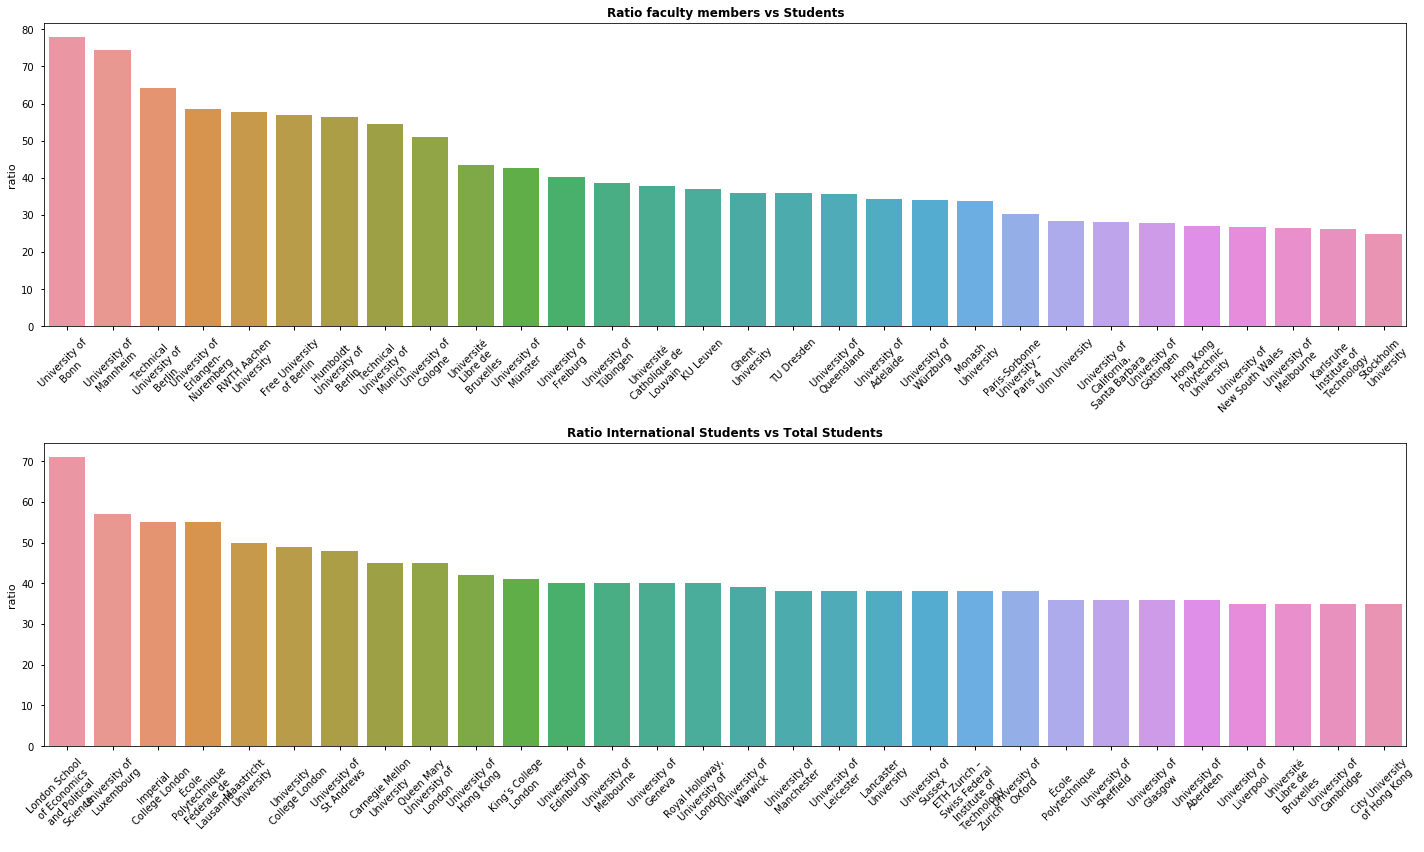

In [18]:
N_TOP = 30 #plot only the 30th first
fig, axes = plt.subplots(2, 1, figsize=(20,12))
# Ratio faculty_tot / student_tot
fac_vs_stu = the_df['stats_student_staff_ratio'].sort_values(ascending=False)
mean_fac_vs_stu = fac_vs_stu.mean()
nice_bar_plot(fac_vs_stu.iloc[:N_TOP], title='Ratio faculty members vs Students', y_axis='ratio', ax=axes[0])
# Ratio student_int / student_tot
stu_vs_int = the_df['stats_pc_intl_students'].sort_values(ascending=False)
mean_stu_vs_int = stu_vs_int.mean()
nice_bar_plot(stu_vs_int.iloc[:N_TOP], title='Ratio International Students vs Total Students', y_axis='ratio', ax=axes[1])
plt.tight_layout()

print("Mean of staff vs student ratio : {:0.2f}%".format(mean_fac_vs_stu))
print("Mean of international student vs student total ratio : {:0.2f}%".format(mean_stu_vs_int))

* (a) We can notice that the universities with the higher staff/student ratio are, as for the Top University ranking, not the one that are best ranked in the global ranking. The mean is 17.79% which might seem a bit low and very less from the ratio displayed. We could consider this as a proof that a good university needs high-qualified staff but not necessarily many of them.
* (b) Here again, we can notice that university with higher ratio of international student are not the best ranked. We can notice some very international universities with a ratio much higher than the average of 21.86% that we could compute.

### (c) `Country`
Same logic as before, except we group entries by `country`

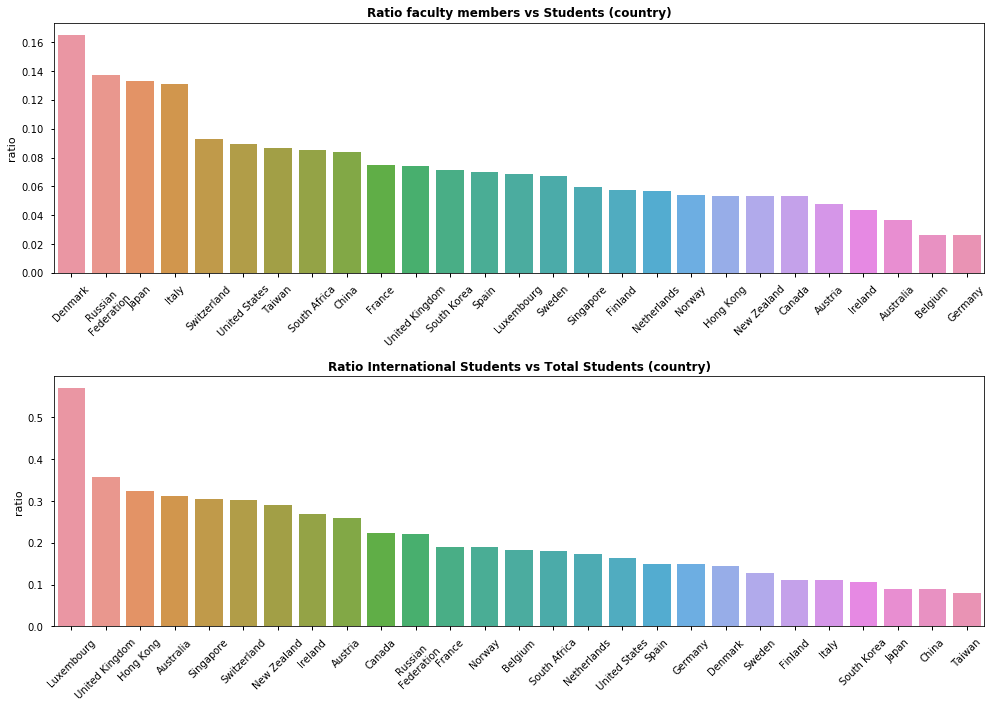

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(14,10))
# Ratio faculty_tot / student_tot (country)
fac_vs_stu = the_df.groupby('country')['faculty_tot'].sum().div(the_df.groupby('country')['student_tot'].sum())\
                .sort_values(ascending=False).iloc[:N_TOP]
nice_bar_plot(fac_vs_stu, title='Ratio faculty members vs Students (country)', y_axis='ratio', ax=axes[0])
# Ratio student_int / student_tot
stu_vs_int = the_df.groupby('country')['student_int'].sum().div(the_df.groupby('country')['student_tot'].sum())\
                .sort_values(ascending=False).iloc[:N_TOP]
nice_bar_plot(stu_vs_int, title='Ratio International Students vs Total Students (country)', y_axis='ratio', ax=axes[1])
plt.tight_layout()

When grouping by country, as for the Top University ranking, we see that for the ratio of faculty members vs students, the countries with most universities in the top 50 (USA and UK) do not have a very high ratio value (les than 10% for both of them).

In this chart, we can see that Luxembourg is really higher than the other countries (~55%) which is different from the Top University ranking. Otherwise, we can see similar results with Australia around 35% and more or less the same ranking following. Globally we can also notice that in the Times Ranking, less countries are displayed.

### (d) `Region`

Note that we do not have information about the region for this dataframe. What we can do is match the region according to the first dataframe (TopUniversities). However we have to check afterward if **all** countries have been matched.

In [20]:
# Create matching dictionarry with 'country': 'region'. Entry would be unique
region_dictionary = dict(zip(top_uni_df['country'].values, top_uni_df['region'].values))
# Apply dictionnary substitution on country times
the_df['region'] = the_df['country'].replace(region_dictionary)
the_df['region'].unique()

array(['Europe', 'North America', 'Asia', 'Oceania', 'Africa',
       'Luxembourg', 'Russian Federation'], dtype=object)

Two countries were note matched. It is either due to the fact that there are no occurence of those countries in the first dataframe, either to the fact that the name is not the same. Let's manually assigne thoses matches.

In [21]:
the_df.loc[the_df['region']=='Luxembourg', 'region'] = 'Europe'
the_df.loc[the_df['region']=='Russian Federation', 'region'] = 'Europe'

Now same logic as before, except we need to group entries by `region`.

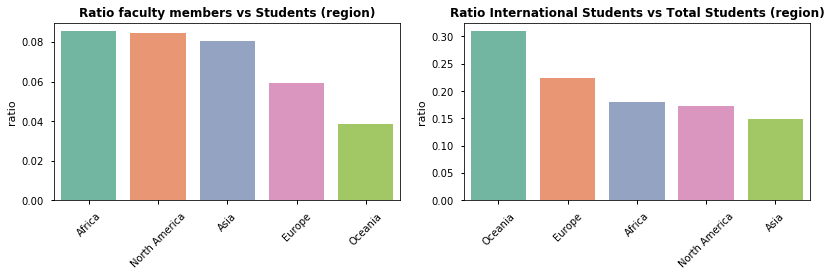

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
# Ratio faculty_tot / student_tot (country)
fac_vs_stu = the_df.groupby('region')['faculty_tot'].sum().div(the_df.groupby('region')['student_tot'].sum())\
                .sort_values(ascending=False)
nice_bar_plot(fac_vs_stu, title='Ratio faculty members vs Students (region)', y_axis='ratio', ax=axes[0])
# Ratio student_int / student_tot
stu_vs_int = the_df.groupby('region')['student_int'].sum().div(the_df.groupby('region')['student_tot'].sum())\
                .sort_values(ascending=False)
nice_bar_plot(stu_vs_int, title='Ratio International Students vs Total Students (region)', y_axis='ratio', ax=axes[1])
plt.tight_layout()


Now we can see that the region with the higher ratio of faculty member vs student is Africa which is different from the other ranking (TopUniversities) and is quite surprising after having seen the average graph (a) where Europe was really important. Note that in this case North America have a low ratio of International Students. 

#### Saving dataframe
Same as for the previous dataframe, we can save it to a csv file to avoid scrapping the data again. Before doing so, we can drop the columns `stats_pc_intl_students` and `stats_student_staff_ratio` that are no longer required and that will find no matched in the top university dataframe. We also drop `region` since this column will be redundant when merging the two dataframes.

In [23]:
the_df.drop(['stats_pc_intl_students', 'stats_student_staff_ratio', 'region'], axis=1, inplace=True)
the_df.to_csv('the.csv')

# 3. Merge data

We are asked to merge data according to the name of the university from each ranking. After some data exploration, it appeared clearly that we would have a problem as in the Time Higher Education ranking the names of university are all translated to english, whereas in the Top University ranking the name of universities where kept in there original langages for most universities. Knowing that, we decided to have an approach by country to minimize the errors of matching name.

In [24]:
# if needed, reload dataset saved previously
the_df = pd.read_csv('the.csv', index_col='title')
top_uni_df = pd.read_csv('top_uni.csv', index_col='title')

As stated above, we have an approach by country. First of all, we check if there are countries that appear in only one of the two dataframes, i.e. there will be no possible match of university name from countries that are not present in both datasets.

In [25]:
data = np.concatenate((top_uni_df['country'].unique(), the_df['country'].unique()))
name, count = np.unique(data, return_counts=True)
print(name[count == 1])

['Argentina' 'Brazil' 'Chile' 'India' 'Israel' 'Luxembourg' 'Malaysia'
 'Mexico' 'Russia' 'Russian Federation' 'Saudi Arabia']


We see that there is a special case for Russia, named Russian Federation in one dataset and Russia in an other. We correct this and check which universities are listed for Russia in each dataframe.

In [26]:
print('Russian university to compare:\n\t{}\n\t{}'.format(
    the_df[the_df['country'] == 'Russian Federation'].index.values,
    top_uni_df[top_uni_df['country'] == 'Russia'].index.values))

the_df.loc[the_df['country'] == 'Russian Federation', 'country'] = 'Russia'

Russian university to compare:
	['Lomonosov Moscow State University']
	['Lomonosov Moscow State University']


We can now remove some "stop words", meaning that we remove words with high occurence that will not be relevant to inspect similarities in the name of university. Note that some words might occur often but are actually relevant. For example `London` is actually a usefull word and allows match between UK cities univerities.

In [27]:
n_occur = 5
stop_w, count_w = np.unique(the_df.index.str.cat(sep=' ').split(' '), return_counts=True)
print('Words that occurs more that {} times: {}'.format(n_occur, stop_w[count_w >= n_occur]))

Words that occurs more that 5 times: ['California,' 'College' 'Hong' 'Institute' 'Kong' 'London' 'Science'
 'State' 'Technology' 'University' 'and' 'of']


We add the most relevant stop words from before. We also add German translation since it helps our matching algorithm to perform better for Germany universities 

In [28]:
def remove_stop(name):
    stops = ['university', 'of', 'the', 'technology', 'de', 'institute', 
             'Universität', 'Universitaet', 'zu', 'technical']
    for stop in stops:
        name= name.replace(stop, '')
    return name

From this point, we are going to use SequenceMatcher from the difflib Library. The function is based on Ratcliff/Obershelp pattern recognition algorithm. It compute the similarity of two strings as the number of matching characters divided by the total number of characters in the two strings. For more information check [Comparison of Jaro-Winkler and Ratcliff/Obershelp algorithms in spell check](https://ilyankou.files.wordpress.com/2015/06/ib-extended-essay.pdf) (p.11-13).

Note that we will look for matching university names by **country**. This technic will improve computational time and remove absurd matching between universites located in 2 different countries.

In [29]:
from difflib import SequenceMatcher

data = []
for country, the_country in the_df.groupby('country'):  # Iteration over sub datasets (country grouping)
    top_uni_country = top_uni_df.loc[top_uni_df['country'] == country]  # Match only in same country
    if len(top_uni_country) == 0:  # No country find in other dataset -> skip
        continue
    for name_the in the_country.index:   # Iteration our university name
        score = np.zeros(len(top_uni_country.index))
        for i, name_top in enumerate(top_uni_country.index):  # Compare with other data set entries
            score[i] = SequenceMatcher(None, remove_stop(name_top.lower()), 
                                       remove_stop(name_the.lower())).ratio() #Gives us a score number between sequences in both lists
        # Append best score
        data.append([name_the, top_uni_country.index[np.argmax(score)], np.max(score), country])

Now that we found the best match for each of the universities we can create a DataFrame and fix a threshold value, i.e. confidence interval.

In [30]:
# Create datafram with scores, names and countries
df = pd.DataFrame(data,  columns=['title_the', 'title_top', 'match_score', 'country'])

The threshold is fixed to 0.7. Note that this value is arbitrary. It was selected after looking at the matched names. One can see that for values above 0.7 we start having meningfull matching. Also, not all names are matched properly. We will investigate it later.

In [31]:
# Show only values with better than 0.7 confidence
df[df['match_score'] > 0.7].sort_values('match_score').head()

,title_the,title_top,match_score,country
196,University of Massachusetts,Massachusetts Institute of Technology (MIT),0.702703,United States
40,Humboldt University of Berlin,Humboldt-Universität zu Berlin,0.711111,Germany
137,California Institute of Technology,California Institute of Technology (Caltech),0.722222,United States
87,Korea Advanced Institute of Science and Techno...,KAIST - Korea Advanced Institute of Science & ...,0.722222,South Korea
37,LMU Munich,Technical University of Munich,0.736842,Germany


In [32]:
# Show only values with less or equal than 0.7 confidence
df[df['match_score'] <= 0.70].sort_values('match_score', ascending=False).head()

,title_the,title_top,match_score,country
129,University of Leicester,The University of Exeter,0.700000,United Kingdom
5,University of New South Wales,The University of New South Wales (UNSW Sydney),0.693878,Australia
69,Wageningen University & Research,Wageningen University,0.666667,Netherlands
49,Charité - Universitätsmedizin Berlin,Humboldt-Universität zu Berlin,0.656250,Germany
63,Scuola Superiore Sant’Anna,Scuola Normale Superiore di Pisa,0.655172,Italy


Let's focus on the duplicates, i.e. Universities names that were matched twice or more

In [33]:
matched = df[df['match_score'] > 0.70]
duplicates = matched[matched.duplicated(subset='title_top')]['title_top']
matched.set_index(['title_top']).loc[duplicates]

,title_the,match_score,country
title_top,,,
Technical University of Munich,LMU Munich,0.736842,Germany
Technical University of Munich,Technical University of Munich,1.000000,Germany
University of Göttingen,University of Tübingen,0.761905,Germany
University of Göttingen,University of Göttingen,1.000000,Germany
"University of California, Santa Barbara (UCSB)","University of California, Santa Barbara",0.885246,United States
"University of California, Santa Barbara (UCSB)","University of California, Santa Cruz",0.758621,United States
Massachusetts Institute of Technology (MIT),Massachusetts Institute of Technology,0.842105,United States
Massachusetts Institute of Technology (MIT),University of Massachusetts,0.702703,United States
Northwestern University,Northwestern University,1.000000,United States


One solution to deal with it, is to take into account only the best match for a specific name. So other matches with lower confidence will be droped. We can after create a dictionnary matching `title_top` and `title_the` names, i.e. we will replace `title_top` names with `title_the` ones.

In [34]:
matched = matched.sort_values('match_score', ascending=False).drop_duplicates(subset='title_top')

In [35]:
# Create dictionnary entries to replace old name with new one (same names to make merge easier)
renamed_index = dict(zip(top_uni_df.loc[matched['title_top']].index.values, 
                         the_df.loc[matched['title_the']].index.values))
top_uni_df.rename(index=renamed_index, inplace=True)
# top_uni_df.loc[matched['title_the']].head()

Since we matched names for both dataframes, we can merge them using `title` field. We add suffixes to keep data from both tables, i.e. `rank` will become `rank_times` and `rank_top`. Note that we create a column `is_epfl` which contains only 0 except for EPFL entry (=1). It will be used to plot EPFL with distinct color at the end.

In [36]:
df_final = pd.merge(top_uni_df, the_df, right_index=True, left_index=True, 
                    how='inner', suffixes=('_top', '_times'))
df_final.drop(['url', 'country_top', 'country_times', 'faculty_int'], axis=1, inplace=True)
df_final['is_epfl'] = df_final.index == 'École Polytechnique Fédérale de Lausanne'
df_final.head()

,region,rank_display_top,score_top,faculty_tot_top,student_tot_top,student_int_top,rank_display_times,score_times,student_tot_times,student_int_times,faculty_tot_times,is_epfl
title,,,,,,,,,,,,
Massachusetts Institute of Technology,North America,1.0,100.0,2982.0,11067.0,3717.0,5.0,92.5,11177,3800,1285,False
Stanford University,North America,2.0,98.7,4285.0,15878.0,3611.0,3.0,93.0,15845,3486,2113,False
Harvard University,North America,3.0,98.4,4350.0,22429.0,5266.0,6.0,91.8,20326,5285,2284,False
California Institute of Technology,North America,4.0,97.7,953.0,2255.0,647.0,3.0,93.0,2209,596,340,False
University of Cambridge,Europe,5.0,95.6,5490.0,18770.0,6699.0,2.0,93.2,18389,6436,1687,False


So now, we have two dataframes with universities from both rankings, their countries, ranks and matching scores. We can see that 148 universities were matched which is already a good score.

In [37]:
print('Matched universities: {}, ratio: {}'.format(len(df_final), len(df_final)/200))

Matched universities: 148, ratio: 0.74


If we take a look at the matches locations we can see that most of top ranked Universities are matched. This is due to the fact that the lower we get in one ranking, the less likely it is that a specific university is part of the top 200 for both rankings.

In [38]:
df_final_times = pd.cut(df_final['rank_display_times'], [0, 5, 15, 50, 100, 200])
print('Named matched for Times ranking:\n{}'.format(df_final_times.value_counts(sort=False).cumsum()))

Named matched for Times ranking:
(0, 5]          5
(5, 15]        15
(15, 50]       48
(50, 100]      91
(100, 200]    148
Name: rank_display_times, dtype: int64


In [39]:
df_final_times = pd.cut(df_final['rank_display_top'], [0, 5, 15, 50, 100, 200])
print('Named matched for Top Universities ranking:\n{}'.format(df_final_times.value_counts(sort=False).cumsum()))

Named matched for Top Universities ranking:
(0, 5]          5
(5, 15]        15
(15, 50]       48
(50, 100]      90
(100, 200]    148
Name: rank_display_top, dtype: int64


# 4. Results and Correlation
To look at correlation one way will be to simply compute the correlation between two features. This will give us a number between [-1 and 1] that indicates how correlated both features are. However we will only have a numerical value. We choosed to use pairplot function from seaborn to look at the repartition of the features.

For example we can see that `student_tot_top` and `student_tot_times` as well as `student_int_top` and `student_int_times` are correlated. This is not a suprise since the number of students should differs between the two ranking. Some similar distribution was expected for the staff number (`faculty_tot_times` and `faculty_tot_top`), but they seems to differ a lot if we consider universities with huge number of faculty members. This is probably due to the fact that both ranking do not consider the same professions as part of faculty members.

We can also observed that both ranking (`rank_display_top` and `rank_display_times`) are correlated for the top 30. There are no outliers such as a university ranked as 4th in one ranking and 55th in the other.

The last correlation we can distiguish is the relation between number of students and faculty members. This results is also not suprising since the more students the university has the more faculty members it needs. 

Note that EPFL dot is displayed in a different color. We can see that there are some huge differences between both ranking.

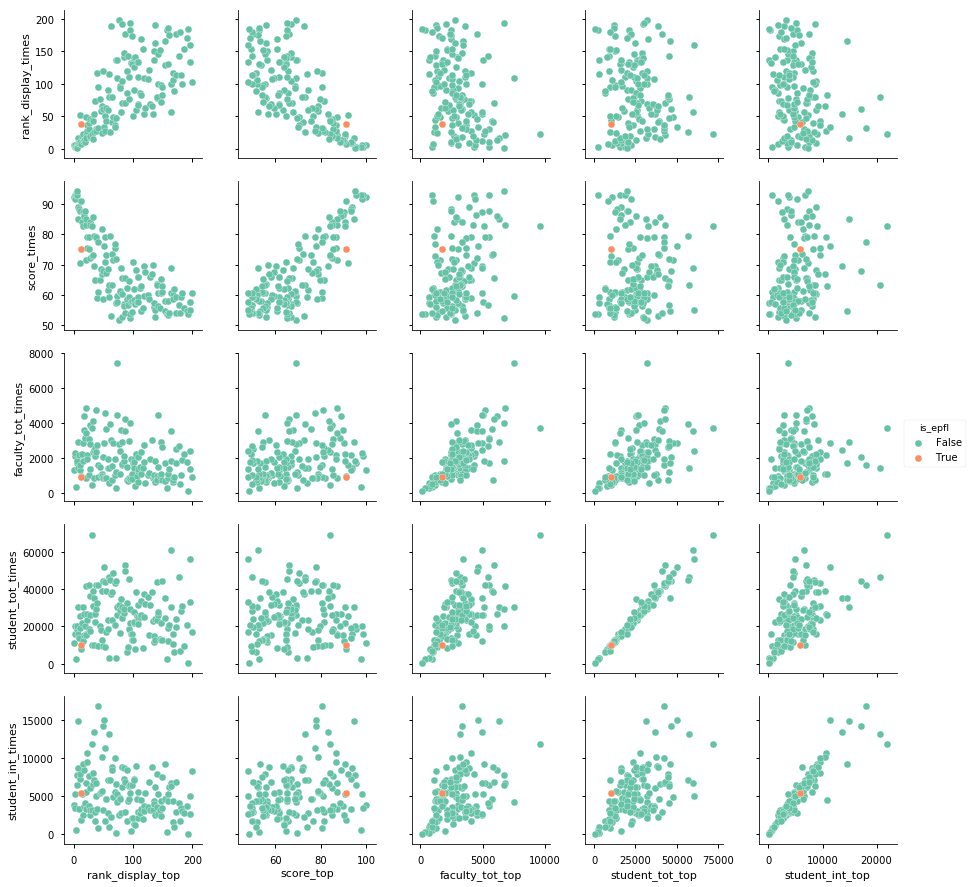

In [40]:
sns.pairplot(df_final, hue='is_epfl',
             x_vars=['rank_display_top', 'score_top', 'faculty_tot_top', 'student_tot_top', 'student_int_top'],
             y_vars=['rank_display_times', 'score_times', 'faculty_tot_times', 'student_tot_times', 'student_int_times'])

In those two plot we were concerned by finding what features were important for the final ranking. However we can see that there are no clear contributions. However it seems that the ratio between the number of faculty members and the number of student is important for `TopUniversities` final ranking.

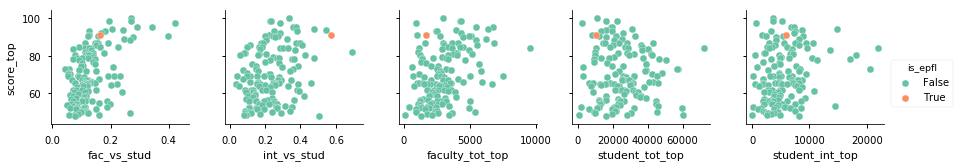

In [41]:
df_final['fac_vs_stud'] = df_final['faculty_tot_top']/df_final['student_tot_top']
df_final['int_vs_stud'] = df_final['student_int_top']/df_final['student_tot_top']

sns.pairplot(df_final, hue='is_epfl',
             y_vars=['score_top'],
             x_vars=['fac_vs_stud', 'int_vs_stud', 'faculty_tot_top', 'student_tot_top', 'student_int_top'])

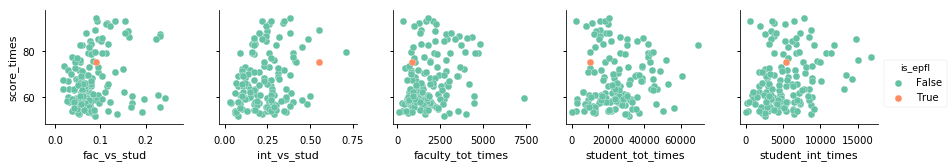

In [42]:
df_final['fac_vs_stud'] = df_final['faculty_tot_times']/df_final['student_tot_times']
df_final['int_vs_stud'] = df_final['student_int_times']/df_final['student_tot_times']

sns.pairplot(df_final, hue='is_epfl',
             y_vars=['score_times'],
             x_vars=['fac_vs_stud', 'int_vs_stud', 'faculty_tot_times', 'student_tot_times', 'student_int_times'])

# 5. Best University
To find the best university we need to use the results of both ranking. We can for example select our own features that we consider as important and sum them. However is is difficult for us to judge what features should be more important. Another solution is to merge both scores using `mean` or `sum` function. Thoses functions will provide an estimate of the best university but will not take into account huge gaps between the two rankings. For example if a university is scoring 95 and 30 (=125), it will be ranked above another one that scored 62 and 62 (=124). We think consistency is an important feature. Therefor we use [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) that care about gaps between values and that is expressed as:
$$ H = \frac{N}{\sum^N_{i=1} \frac{1}{s_i}} $$


Using the function MIT is the top ranked university with 96.1.

In [43]:
df_final['score_mean'] = scipy.stats.hmean([df_final['score_times'], df_final['score_top']])
df_final['final_rank'] = np.arange(len(df_final))+1
df_final.sort_values('score_mean', ascending=False, inplace=True)
df_final[['final_rank', 'score_mean', 'score_top', 'score_times']].head(10)

,final_rank,score_mean,score_top,score_times
title,,,,
Massachusetts Institute of Technology,1,96.103896,100.0,92.5
Stanford University,2,95.765258,98.7,93.0
California Institute of Technology,4,95.292082,97.7,93.0
Harvard University,3,94.985489,98.4,91.8
University of Oxford,6,94.797363,95.3,94.3
University of Cambridge,5,94.384746,95.6,93.2
Imperial College London,8,91.394642,93.7,89.2
Princeton University,13,91.049973,91.0,91.1
University of Chicago,9,90.984075,93.5,88.6


## 5.1 What about EPFL ?
EPFL will be ranked 12th worldwide and 7th best university in Europe, according to this ranking. Note that this is mainly due to the fact that there is a huge gap between the 2 scores (91.2 and 75.3).

In [44]:
df_final[['final_rank', 'score_mean', 'score_top', 'score_times']].loc['École Polytechnique Fédérale de Lausanne']

final_rank     12.000000
score_mean     82.490811
score_top      91.200000
score_times    75.300000
Name: École Polytechnique Fédérale de Lausanne, dtype: float64

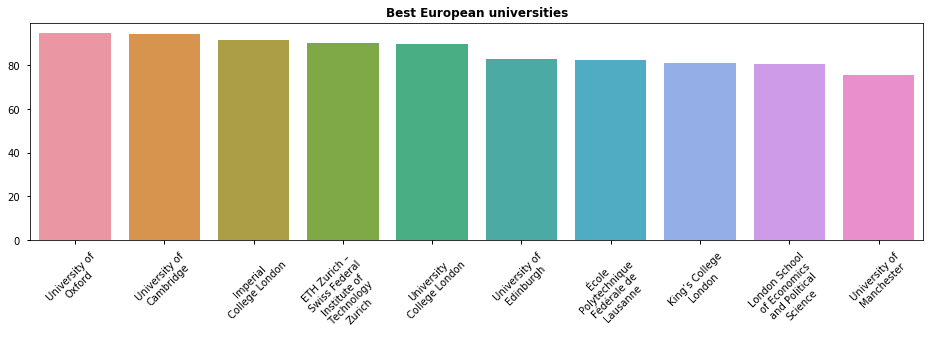

In [45]:
N_TOP = 10
fig, ax = plt.subplots(1, 1, figsize=(16,4))
df_europe = df_final.loc[df_final['region']=='Europe']
nice_bar_plot(df_europe['score_mean'][:N_TOP], ax, title='Best European universities')